In [1]:
import numpy as np
import pandas as pd
import os
from shutil import copyfile
import pickle
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import colorlover as cl


import neuro_morpho_toolbox as nmt
%matplotlib inline
import pickle
pickle_in = open("/home/penglab/FeaCal/all_ns.pickle","rb")
[ns] = pickle.load(pickle_in)


/home/penglab/anaconda3/lib/python3.7/site-packages/neuro_morpho_toolbox-0.1-py3.7.egg/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 0.95
Loading CCF brain structure data...
Loading time: 0.00


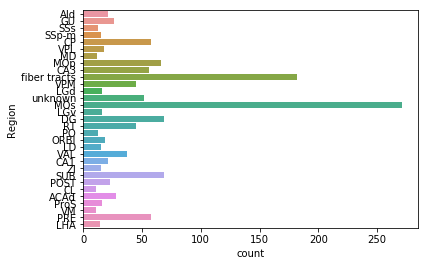

In [2]:
sf = ns.features['soma_features'].region
ct = sf["Region"].value_counts().sort_values(ascending=False)
_ = sns.countplot(y="Region", 
                  data=sf.loc[sf.Region.isin(ct.index[ct>10])],
                 )

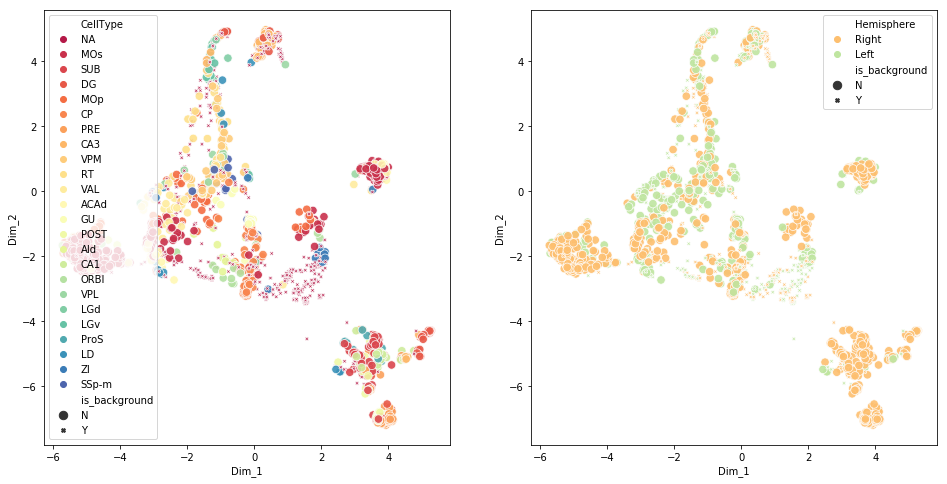

In [3]:
_ = ns.ReduceDimUMAP(feature_set="projection_features", n_neighbors=100)
_ = ns.FeatureScatter(["CellType", "Hemisphere"], map="UMAP")

### Read the downsample-25 array with selected CCF region

In [4]:
pickle_in = open("/home/penglab/NMTcode/ccf_25.pickle","rb")
example_ = pickle.load(pickle_in)
ccfArray= example_[0]

### Read the 6-nearest neighbor 0-1 Contour Matrix 

In [5]:
pickle_in = open("/home/penglab/NMTcode/CCF_6_01.pickle","rb")
example_ = pickle.load(pickle_in)
CCF_6_01= example_[0]==1

### Read the 6-nearest neighbor Contour Matrix with CCF index on

Originally, CCF has 316 regions, after using all the CCF index to replace the child region, there are 337 regions/
Besides, there are 23 regions that show up in the nrrd array but have not been mentioned in CCF or its child region

In [6]:
pickle_in = open("/home/penglab/NMTcode/CCF_6_M.pickle","rb")
example_ = pickle.load(pickle_in)
CCF_6_M = example_[0]

### function writeNRRD(input_M, IDlist, path, flipF = True)
* **input_M** is a sparse matrix, with value indicating ID on each point(mostly 0)
* **IDlist** is a list of ID to output
* **path** is the path to store, do not need to end with '/'
* **flipF** indicates whether illustrate half part of the result or to illustrate the full result

In [7]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import shutil

def writeNRRD(input_M, IDlist, path, flipF = True):
    assert type(IDlist) ==list, "Please using list to input the interested regionID"
    folder = os.path.exists(path)
    if not folder:         
        os.makedirs(path)  
    data = np.zeros(input_M.shape)
    for iterID in IDlist:
        data[input_M==iterID]=1
    filename = str(path)+ '/'
    for iterID in IDlist:
        filename = filename + str(iterID)
        filename = filename + '_'
    filename = filename +'.nrrd'
    itkimage = sitk.GetImageFromArray(data, isVector=False)
    sitk.WriteImage(itkimage, filename, True) 
    co_1,co_2,co_3 = np.where(data ==1)
    if flipF:
        co_1 = co_1[co_3<=nmt.annotation.size['z']//2]
        co_2 = co_2[co_3<=nmt.annotation.size['z']//2]
        co_3 = co_3[co_3<=nmt.annotation.size['z']//2]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    # Plot defining corner points
    ax.plot(co_1, co_2,co_3, "y.")
    # Make axis label
    for i in ["x", "y", "z"]:
        eval("ax.set_{:s}label('{:s}')".format(i, i))
    plt.show()


writeNRRD(CCF_6_M ,[985] ,'/home/penglab/NMTcode/nrrdTEST',True)

### function disCal(SOMA_raw,Contour_Matrix, flipF = True, near_n)

calculate the distance among region contour, record the nearest near_n
* **SOMA_raw** input dataframe of soma feature: 
* **Contour_Matrix** =1 for contour points, = 0 for others
* **near_n** number of closest contour points to record
* **flipF** flag to indicate whether flip the soma location or not. Defalt is True


In [8]:
from scipy.spatial import distance
import ast
import time
def disCal(SOMA_raw,Contour_01,Array_ID, near_n, flipF = True):
    assert near_n>0, "The number of nearest contour points should be bigger than 0"
    start = time.time()
    scaledDF = pd.DataFrame()
    scaledDF["x"] = (SOMA_raw["x"] / nmt.annotation.space["x"]).copy()
    scaledDF["y"] = (SOMA_raw["y"] / nmt.annotation.space["y"]).copy()
    scaledDF["z"] = (SOMA_raw["z"] / nmt.annotation.space["z"]).copy()
    #flip the somalocation
    if flipF:
        scaledDF["z"][scaledDF['z']>(nmt.annotation.size["z"]//2)] = scaledDF["z"][scaledDF["z"]>(nmt.annotation.size['z']//2)] -nmt.annotation.size["z"]//2 
    i_p = 0
    for idx in scaledDF.index.tolist():
        i_p = i_p+1
        tempCoor = np.array([[scaledDF.loc[idx,'x'],scaledDF.loc[idx,'y'],scaledDF.loc[idx,'z']]])
        tempID = Array_ID[int(scaledDF.loc[idx,'x']),int(scaledDF.loc[idx,'y']),int(scaledDF.loc[idx,'z'])]
        coords = []
        if tempID == 0:
            scaledDF.loc[idx,'SqEuclidean'] = str([0])
            continue
        Mask_temp = np.multiply(Array_ID == tempID,Contour_01)#Contour for this tempID
        co_1_temp,co_2_temp,co_3_temp = np.where( Mask_temp >0)
        for icoor in range(len(co_1_temp)):
            coords.append([co_1_temp[icoor], co_2_temp[icoor], co_3_temp[icoor]])
        zs = np.sort(distance.cdist(tempCoor,coords, 'sqeuclidean'))[0,0:min(near_n,distance.cdist(tempCoor,coords, 'sqeuclidean').shape[1])]
        scaledDF.loc[idx,'SqEuclidean'] = str(zs.tolist())
        scaledDF.loc[idx,'min_Euclidean'] = np.sqrt(float(scaledDF.loc[idx,'SqEuclidean'].strip('[]').split(",")[0]))
        if ip%10 ==0：
            print('Load progress: %.5f'% (i_p/scaledDF.shape[0]))
    end = time.time()
    print("Total loading time: %.2f" % (end-start))
    scaledDF = scaledDF.fillna(str([0]))
    scaledDF['min_Euclidean'] = scaledDF.min_Euclidean.astype(float)
    return scaledDF.copy()

In [9]:
somaDis = disCal(ns.features['soma_features'].raw_data,CCF_6_01,ccfArray,10 ,flipF = True)

Load progress: 0.00063
Load progress: 0.00126
Load progress: 0.00189
Load progress: 0.00252
Load progress: 0.00315
Load progress: 0.00378
Load progress: 0.00441
Load progress: 0.00504
Load progress: 0.00567
Load progress: 0.00630
Load progress: 0.00693
Load progress: 0.00756
Load progress: 0.00819
Load progress: 0.00882
Load progress: 0.00945
Load progress: 0.01008
Load progress: 0.01071
Load progress: 0.01134
Load progress: 0.01260
Load progress: 0.01323
Load progress: 0.01386
Load progress: 0.01449
Load progress: 0.01512
Load progress: 0.01575
Load progress: 0.01638
Load progress: 0.01701
Load progress: 0.01764
Load progress: 0.01827
Load progress: 0.01890
Load progress: 0.01953
Load progress: 0.02016
Load progress: 0.02079
Load progress: 0.02142
Load progress: 0.02205
Load progress: 0.02268
Load progress: 0.02331
Load progress: 0.02394
Load progress: 0.02457
Load progress: 0.02520
Load progress: 0.02583
Load progress: 0.02710
Load progress: 0.02773
Load progress: 0.02836
Load progre

Load progress: 0.24386
Load progress: 0.24449
Load progress: 0.24512
Load progress: 0.24575
Load progress: 0.24638
Load progress: 0.24701
Load progress: 0.24764
Load progress: 0.24827
Load progress: 0.24890
Load progress: 0.24953
Load progress: 0.25016
Load progress: 0.25079
Load progress: 0.25142
Load progress: 0.25205
Load progress: 0.25268
Load progress: 0.25331
Load progress: 0.25394
Load progress: 0.25457
Load progress: 0.25520
Load progress: 0.25583
Load progress: 0.25646
Load progress: 0.25709
Load progress: 0.25772
Load progress: 0.25835
Load progress: 0.25898
Load progress: 0.25961
Load progress: 0.26024
Load progress: 0.26087
Load progress: 0.26150
Load progress: 0.26213
Load progress: 0.26276
Load progress: 0.26339
Load progress: 0.26402
Load progress: 0.26465
Load progress: 0.26528
Load progress: 0.26591
Load progress: 0.26654
Load progress: 0.26717
Load progress: 0.26780
Load progress: 0.26843
Load progress: 0.26906
Load progress: 0.26969
Load progress: 0.27032
Load progre

Load progress: 0.50599
Load progress: 0.50662
Load progress: 0.50725
Load progress: 0.50788
Load progress: 0.50851
Load progress: 0.50914
Load progress: 0.50977
Load progress: 0.51040
Load progress: 0.51103
Load progress: 0.51166
Load progress: 0.51229
Load progress: 0.51292
Load progress: 0.51355
Load progress: 0.51418
Load progress: 0.51481
Load progress: 0.51544
Load progress: 0.51607
Load progress: 0.51670
Load progress: 0.51733
Load progress: 0.51796
Load progress: 0.51859
Load progress: 0.51922
Load progress: 0.51985
Load progress: 0.52048
Load progress: 0.52174
Load progress: 0.52237
Load progress: 0.52300
Load progress: 0.52363
Load progress: 0.52426
Load progress: 0.52489
Load progress: 0.52552
Load progress: 0.52615
Load progress: 0.52678
Load progress: 0.52741
Load progress: 0.52804
Load progress: 0.52867
Load progress: 0.52930
Load progress: 0.52993
Load progress: 0.53056
Load progress: 0.53182
Load progress: 0.53245
Load progress: 0.53308
Load progress: 0.53371
Load progre

Load progress: 0.88091
Load progress: 0.88154
Load progress: 0.88217
Load progress: 0.88280
Load progress: 0.88343
Load progress: 0.88406
Load progress: 0.88469
Load progress: 0.88532
Load progress: 0.88658
Load progress: 0.88721
Load progress: 0.88784
Load progress: 0.88847
Load progress: 0.88910
Load progress: 0.88973
Load progress: 0.89036
Load progress: 0.89099
Load progress: 0.89162
Load progress: 0.89225
Load progress: 0.89288
Load progress: 0.89351
Load progress: 0.89414
Load progress: 0.89477
Load progress: 0.89666
Load progress: 0.90233
Load progress: 0.90485
Load progress: 0.90548
Load progress: 0.90611
Load progress: 0.90674
Load progress: 0.90737
Load progress: 0.90989
Load progress: 0.91115
Load progress: 0.91304
Load progress: 0.91367
Load progress: 0.91556
Load progress: 0.91871
Load progress: 0.91997
Load progress: 0.92250
Load progress: 0.92376
Load progress: 0.92439
Load progress: 0.92502
Load progress: 0.92628
Load progress: 0.92880
Load progress: 0.92943
Load progre

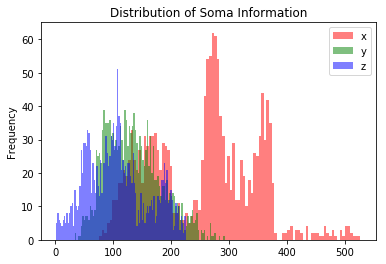

In [65]:
x1 = somaDis.loc[:, 'x']
x2 = somaDis.loc[:, 'y']
x3 = somaDis.loc[:, 'z']
x4 = somaDis.loc[:, 'min_Euclidean']

assert 'O' not in [x1.dtype, x2.dtype, x3.dtype, x4.dtype],"The data type of input series should not be object"
kwargs = dict(alpha=0.5, bins=100)

plt.hist(x1, **kwargs, color='r', label='x')
plt.hist(x2, **kwargs, color='g', label='y')
plt.hist(x3, **kwargs, color='b', label='z')
plt.gca().set(title='Distribution of Soma Information', ylabel='Frequency')
#plt.xlim(50,75)
plt.legend();


### 1171 neurons having soma located inside the regions: selectedDF

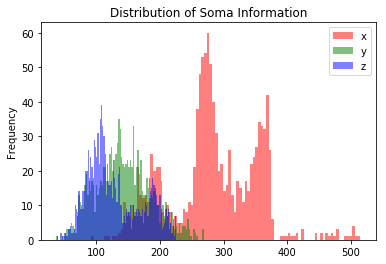

In [78]:
selectedDF = somaDis[somaDis['SqEuclidean'] != str([0])].copy()

x1 = selectedDF.loc[:, 'x']
x2 = selectedDF.loc[:, 'y']
x3 = selectedDF.loc[:, 'z']
x4 = selectedDF.loc[:, 'min_Euclidean']

assert 'O' not in [x1.dtype, x2.dtype, x3.dtype, x4.dtype],"The data type of input series should not be object"
kwargs = dict(alpha=0.5, bins=100)

plt.hist(x1, **kwargs, color='r', label='x')
plt.hist(x2, **kwargs, color='g', label='y')
plt.hist(x3, **kwargs, color='b', label='z')
plt.gca().set(title='Distribution of Soma Information', ylabel='Frequency')
#plt.xlim(50,75)
plt.legend();


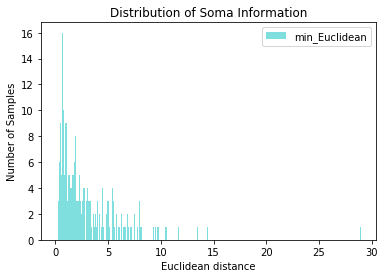

In [76]:

x4 = selectedDF.loc[:, 'min_Euclidean']

assert 'O' not in [x1.dtype, x2.dtype, x3.dtype, x4.dtype],"The data type of input series should not be object"
kwargs = dict(alpha=0.5, bins=1500)

plt.hist(x4, **kwargs, color='c', label='min_Euclidean')
plt.gca().set(title='Distribution of Soma Information', ylabel='Number of Samples', xlabel = 'Euclidean distance')
#plt.xlim(50,75)
plt.legend();

### 416 neurons having soma located outside the regions: zeroDF

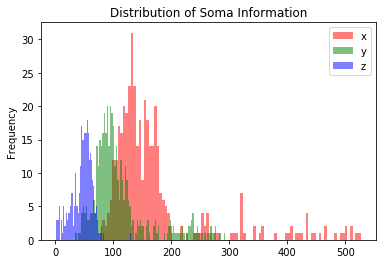

In [79]:
zeroDF = somaDis[somaDis['SqEuclidean'] == str([0])].copy()

x1 = zeroDF.loc[:, 'x']
x2 = zeroDF.loc[:, 'y']
x3 = zeroDF.loc[:, 'z']
x4 = zeroDF.loc[:, 'min_Euclidean']

assert 'O' not in [x1.dtype, x2.dtype, x3.dtype, x4.dtype],"The data type of input series should not be object"
kwargs = dict(alpha=0.5, bins=100)

plt.hist(x1, **kwargs, color='r', label='x')
plt.hist(x2, **kwargs, color='g', label='y')
plt.hist(x3, **kwargs, color='b', label='z')
plt.gca().set(title='Distribution of Soma Information', ylabel='Frequency')
#plt.xlim(50,75)
plt.legend();


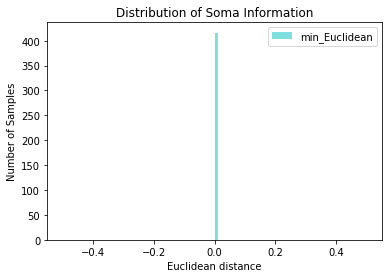

In [89]:

x4 = zeroDF.loc[:, 'min_Euclidean']

assert 'O' not in [x1.dtype, x2.dtype, x3.dtype, x4.dtype],"The data type of input series should not be object"
kwargs = dict(alpha=0.5, bins=100)

plt.hist(x4, **kwargs, color='c', label='min_Euclidean')
plt.gca().set(title='Distribution of Soma Information', ylabel='Number of Samples', xlabel = 'Euclidean distance')
#plt.xlim(50,75)
plt.legend();


In [137]:
To be done

SyntaxError: invalid syntax (<ipython-input-137-5a896f581a9d>, line 1)

In [ ]:
    
    labels_true = np.array(['a','a','b','b','b','b','a','c','c','c','c','c'])
    labels_pred = np.array(['1','1','1','3','4','5','3','4','3','2','5','1'])
    assert labels_true.ndim ==1,"The dimension of true label should be 1"
    assert labels_pred.ndim ==1,"The dimension of predicted  label should be 1"
    assert  labels_true.shape[0] == labels_pred.shape[0],"True and predicted label should have same shape"
    n_samples = labels_true.shape[0]
    n_classes = np.unique(labels_true).shape[0]
    n_clusters = np.unique(labels_pred).shape[0]

    #if (n_classes == n_clusters == 1 or
        #    n_classes == n_clusters == 0 or
           # n_classes == n_clusters == n_samples):
    

    # Compute the ARI using the contingency data
    contingency = contingency_matrix(labels_true, labels_pred, sparse=True)
    sum_comb_c = sum(scipy.special.comb(n_c, 2, exact=1) for n_c in np.ravel(contingency.sum(axis=1)))
    sum_comb_k = sum(scipy.special.comb(n_k, 2, exact=1) for n_k in np.ravel(contingency.sum(axis=0)))
    sum_comb = sum(scipy.special.comb(n_ij, 2, exact=1) for n_ij in contingency.data)

    prod_comb = (sum_comb_c * sum_comb_k) / scipy.special.comb(n_samples, 2, exact=1)
    mean_comb = (sum_comb_k + sum_comb_c) / 2.

### Read the dataframe from the above function in pickCLUSTERpara(method)

In [136]:
import pandas as pd
hier_resultDF = pd.read_excel('/home/penglab/NMTcode/hier_resultDF.xlsx', index_col=0)
kmeans_resultDF = pd.read_excel('/home/penglab/NMTcode/kmeans_resultDF.xlsx', index_col=0)
dbscan_resultDF = pd.read_excel('/home/penglab/NMTcode/dbscan_resultDF.xlsx', index_col=0)
hdbscan_resultDF = pd.read_excel('/home/penglab/NMTcode/hdbscan_resultDF.xlsx', index_col=0)
snn_resultDF = pd.read_excel('/home/penglab/NMTcode/snn_resultDF.xlsx', index_col=0)

### weighted ARI

In [ ]:
from scipy.spatial import distance
import ast
import time
def findBESTpara(inputDF,clusterRange,scaledDF,flipF = True):
    start = time.time()
    inputDF.drop_duplicates(subset=None, keep='first', inplace=True)
    [minR,maxR] = clusterRange
    inputDF = inputDF[inputDF['NumCluster'] >= minR] 
    inputDF = inputDF[inputDF['NumCluster'] <= maxR] 
    i_p = 0
    selectedDF = scaledDF[scaledDF['SqEuclidean'] != str([0])].copy()
    selectedIDX
        i_p = i_p+1
        tempCoor = np.array([[scaledDF.loc[idx,'x'],scaledDF.loc[idx,'y'],scaledDF.loc[idx,'z']]])
        tempID = nmt.annotation.array[int(scaledDF.loc[idx,'x']),int(scaledDF.loc[idx,'y']),int(scaledDF.loc[idx,'z'])]
        coords = []
        if tempID == 0:
            continue
        Mask_temp = (nmt.annotation.array == tempID).copy()
        Mask_temp = np.multiply(Mask_temp,contour_M)
        co_1_temp,co_2_temp,co_3_temp = np.where( Mask_temp >0)
        for icoor in range(len(co_1_temp)):
            coords.append([co_1_temp[icoor], co_2_temp[icoor], co_3_temp[icoor]])
        zs = np.sort(distance.cdist(tempCoor,coords, 'sqeuclidean'))[0,0:min(10,distance.cdist(tempCoor,coords, 'sqeuclidean').shape[1])]
        scaledDF.loc[idx,'SqEuclidean'] = str(zs.tolist())
        
        print('Load progress: %.5f'% (i_p/scaledDF.shape[0]))
    end = time.time()
    print("Total loading time: %.2f" % (end-start))
    return scaledDF.copy()

In [ ]:
testR = findBESTpara(hier_resultDF,[15,45],ns.features['soma_features'].raw_data,flipF = True)

In [169]:
for iter_str in hier_resultDF.loc['Hier0','ClusterINFO'].split("\n"):
    if 'fiber tracts' in iter_str:
        iter_str = iter_str.replace("fiber tracts","fiber_tracts")
    iter_str = iter_str.split()
    print(iter_str )
    print('******')

["[('C1',", 'SomaRegion', 'Hemisphere', 'CellType', 'Cluster']
******
['18454_00163', 'fiber_tracts', 'Left', 'fiber_tracts', 'C1']
******
['18457_00097', 'RT', 'Left', 'RT', 'C1),', "('C10',", 'SomaRegion', 'Hemisphere', 'CellType', 'Cluster']
******
['AA0787', 'MOs', 'Right', 'MOs', 'C10']
******
['AA0899', 'MOs', 'Right', 'MOs', 'C10),', "('C100',", 'SomaRegion', 'Hemisphere', 'CellType', 'Cluster']
******
['18458_00244', 'unknown', 'Left', 'unknown', 'C100),', "('C1000',", 'SomaRegion', 'Hemisphere', 'CellType', 'Cluster']
******
['18457_00117', 'fiber_tracts', 'Left', 'fiber_tracts', 'C1000']
******
['18457_00122', 'fiber_tracts', 'Left', 'fiber_tracts', 'C1000),', "('C1001',", 'SomaRegion', 'Hemisphere', 'CellType', 'Cluster']
******
['18457_00203', 'fiber_tracts', 'Right', 'fiber_tracts', 'C1001),', "('C1002',", 'SomaRegion', 'Hemisphere', 'CellType', 'Cluster']
******
['18457_00120', 'fiber_tracts', 'Left', 'fiber_tracts', 'C1002),', "('C1003',", 'SomaRegion', 'Hemisphere', 'Ce

In [170]:
hier_resultDF.loc['Hier0','ClusterINFO']

"[('C1',                SomaRegion Hemisphere      CellType Cluster\n18454_00163  fiber tracts       Left  fiber tracts      C1\n18457_00097            RT       Left            RT      C1), ('C10',        SomaRegion Hemisphere CellType Cluster\nAA0787        MOs      Right      MOs     C10\nAA0899        MOs      Right      MOs     C10), ('C100',             SomaRegion Hemisphere CellType Cluster\n18458_00244    unknown       Left  unknown    C100), ('C1000',                SomaRegion Hemisphere      CellType Cluster\n18457_00117  fiber tracts       Left  fiber tracts   C1000\n18457_00122  fiber tracts       Left  fiber tracts   C1000), ('C1001',                SomaRegion Hemisphere      CellType Cluster\n18457_00203  fiber tracts      Right  fiber tracts   C1001), ('C1002',                SomaRegion Hemisphere      CellType Cluster\n18457_00120  fiber tracts       Left  fiber tracts   C1002), ('C1003',             SomaRegion Hemisphere CellType Cluster\n18465_00233         RT      Rig

In [168]:
aa = 'a a g d s fiber tracts'
aa=aa.replace("fiber tracts", "fiber_tracts")
aa

'a a g d s fiber_tracts'

In [ ]:
np.sum(M_show!=0)

In [ ]:
regionN, count = np.unique(M_show, return_counts=True)
regionN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull


M_show = np.multiply(nmt.annotation.array.copy(),contour_M_6)

co_1,co_2,co_3 = np.where(M_show ==1016)
#co_1 = co_1[co_3<=nmt.annotation.size['z']//2]
#co_2 = co_2[co_3<=nmt.annotation.size['z']//2]
#co_3 = co_3[co_3<=nmt.annotation.size['z']//2]
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot defining corner points
ax.plot(co_1, co_2,co_3, "b.")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)


# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

plt.show()


In [ ]:
nmt.bs.id_to_name(507)

In [ ]:
testR = testR.fillna('unknown')
testR.to_excel('/home/penglab/NMTcode/testR.xlsx')

In [ ]:
nmt.annotation.size

In [ ]:
nmt.annotation.space

In [ ]:
nmt.annotation.array.shape

In [ ]:
528* 320* 456